In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import random
import seaborn as sns

from collections import Counter

In [2]:
def pre_processamento():
    xlsx = pd.ExcelFile('casos_corona.xlsx')
    df = pd.read_excel(xlsx, 'casos_corona')
    df = df[:10000] ################################limitando o dataset
    df = df[['bairroPaciente','municipioPaciente','resultadoFinalExame','sexoPaciente', 'idadePaciente']]
    
    novo_df = []
    for i in range(len(df)):
        if(df.loc[i][2] == 'Positivo'):
            resultado = 1
            novo_df.append([df.loc[i][0], df.loc[i][1], resultado, df.loc[i][3], df.loc[i][4]])
        else:
            resultado = 0
            novo_df.append([df.loc[i][0], df.loc[i][1], resultado, df.loc[i][3], df.loc[i][4]])
    
    novo_df = pd.DataFrame(novo_df)
    novo_df.rename(columns={0: 'bairro_paciente', 1: 'municipio_paciente', 2: 'resultado_exame', 3: 'sexo_paciente', 4: 'idade_paciente'}, inplace=True)    
    return novo_df

In [3]:
df = pre_processamento()
df

,bairro_paciente,municipio_paciente,resultado_exame,sexo_paciente,idade_paciente
0,VILA PERI,FORTALEZA,0,MASCULINO,74.0
1,VARJOTA,FORTALEZA,0,FEMININO,31.0
2,NOVA METROPOLE JUREMA,CAUCAIA,0,FEMININO,84.0
3,PARQUE POTIRA JUREMA,CAUCAIA,0,FEMININO,61.0
4,PINHEIRO,GUAIÚBA,0,MASCULINO,37.0
...,...,...,...,...,...
9995,CIDADE DOS FUNCIONÁRIOS,FORTALEZA,1,MASCULINO,36.0
9996,PAPICU,FORTALEZA,0,FEMININO,49.0
9997,GURARAPES,FORTALEZA,0,FEMININO,33.0
9998,BOM JARDIM,FORTALEZA,0,FEMININO,46.0


In [4]:
def agrupar_idade(df):
    clusters_idades = []
    intervalos = np.arange(1, 100, dtype=int)
    for i in range(0, 95, 5):
        gaps = []
        for j in range(i, i+5):
            gaps.append(intervalos[j])
        clusters_idades.append(gaps)

    casos_idade = []

    for cluster in clusters_idades:
        count = 0
        for i in range(len(df)):
            if(df.loc[i][4] in cluster):
                count = count + 1
        casos_idade.append(['[{}:{}]'.format(cluster[0], cluster[4]), count])
    casos_idade = pd.DataFrame(casos_idade)
    casos_idade.rename(columns={0: 'idade', 1: 'count'}, inplace=True)
    casos_idade = casos_idade.sort_values(by=['count'], ascending=True)
    ordem = np.arange(1,len(casos_idade)+1)
    casos_idade['ordem'] = pd.Series(ordem, index=casos_idade.index)
    return casos_idade

In [5]:
dataset_idade = agrupar_idade(df)
dataset_idade

,idade,count,ordem
1,[6:10],73,1
18,[91:95],107,2
2,[11:15],108,3
0,[1:5],179,4
17,[86:90],203,5
3,[16:20],245,6
16,[81:85],327,7
15,[76:80],389,8
13,[66:70],466,9
14,[71:75],474,10


In [6]:
def top_k_reverse_idade(dataset, k):
    copia = dataset.copy()
    output = []
    for i in range(k):
        indice = copia['count'].idxmin()
        output.append([copia.loc[indice][0], copia.loc[indice][1]])
        copia.drop(indice, inplace=True,axis=0)
    output = pd.DataFrame(output)
    output = output.rename(columns={0: 'idade', 1: 'count'})
    return output

In [7]:
top_k_reverse_idade(dataset_idade, 10)

,idade,count
0,[6:10],73
1,[91:95],107
2,[11:15],108
3,[1:5],179
4,[86:90],203
5,[16:20],245
6,[81:85],327
7,[76:80],389
8,[66:70],466
9,[71:75],474


# Ruído de Laplace

In [61]:
def sensibilidade_lap(dataset, budget, k):
    smooth_functions = [1]*len(dataset['count'])
    beta = budget/k
    otimo = 0
    for smooth in smooth_functions:
        otimo = max(otimo, (smooth*math.exp(-beta)))
    return otimo

In [51]:
def plot_erros(erros_argumento, k):
    df = pd.DataFrame({
        'epsilon': ['0.1', '1', '3', '5', '8', '10'],
        'F1 Score': erros_argumento })
    sns.catplot(x="epsilon", y="F1 Score", palette="ch:.5",
                data=df, saturation=.7,
                kind="bar", ci=None, aspect=.9, order=['0.1', '1', '3', '5', '8', '10'])

    plt.xlabel("Epsilon")
    plt.ylabel("F1 Score, k = {}".format(k))
    return plt.show()

In [52]:
def f1_score(query, argumento_consulta, budgets):
    top = list(query)
    metrica_exponencial = []
    for argumento, budget in zip(argumento_consulta, budgets):
        falsos_positivos, falsos_negativos, verdadeiros_positivos = 0, 0, 0
        for i in range(len(argumento)):
            if(argumento[i] in top):
                if(argumento[i] == top[i]):
                    verdadeiros_positivos += 1
                else:
                    falsos_positivos += 1
            if(top[i] not in argumento):
                falsos_negativos += 1
            if(argumento[i] not in top):
                falsos_positivos += 1

        print("epsilon = {}:\nVerdadeiros Positivos: {}\nFalsos Positivos: {}\nFalsos Negativos: {}\n\n".format(budget, verdadeiros_positivos, falsos_positivos, falsos_negativos))

        precisao = verdadeiros_positivos/(verdadeiros_positivos + falsos_positivos) 
        revocacao = verdadeiros_positivos/(verdadeiros_positivos + falsos_negativos)

        f1_score = 2*((revocacao * precisao)/(revocacao + precisao))
        metrica_exponencial.append(f1_score)
    
    print(metrica_exponencial)

    return metrica_exponencial

# Consulta Idade com ruído

In [151]:
def laplace_idade(budget, sensibilidade, query, dataset, k):
    resposta_query = np.array(query['count'])
    coluna_idades = np.array(query['idade'])
    output = []
    #np.random.seed(random.randint(0,1000))
    for i in range(k):
        ruido = stats.laplace.rvs(loc = 0, scale = sensibilidade/budget)
        output.append((resposta_query[i] + ruido))
    output = {
        'idade': coluna_idades,
        'count': output
    }
    
    df = pd.DataFrame(output, columns = ['idade', 'count'])
    return df.sort_values(by=['count'],ascending=True)

In [154]:
budgets = [0.1, 1, 3, 5, 8, 10]
idades = []
k = 10
for budget in budgets:
    a = laplace_idade(budget, sensibilidade_lap(dataset_idade, budget, 10), top_k_reverse_idade(dataset_idade, 10), dataset_idade, 10)
    a = np.array(a)
    print("epsilon: {}\nreverse top-k:\n{}\n\n".format(budget, a))
    idades.append(a[:,0])

epsilon: 0.1
reverse top-k:
[['[91:95]' 65.63597638080478]
 ['[6:10]' 70.79579221562898]
 ['[11:15]' 110.19328326638599]
 ['[1:5]' 191.79742064344114]
 ['[86:90]' 206.55678386065495]
 ['[16:20]' 246.05232499183114]
 ['[81:85]' 341.198651024967]
 ['[76:80]' 397.15392236686574]
 ['[71:75]' 463.71152424440004]
 ['[66:70]' 478.7819627593877]]


epsilon: 1
reverse top-k:
[['[6:10]' 72.51229312975295]
 ['[11:15]' 107.39802881417214]
 ['[91:95]' 107.57458833946248]
 ['[1:5]' 181.4087027629303]
 ['[86:90]' 202.13723754181305]
 ['[16:20]' 242.73282597500926]
 ['[81:85]' 326.35228578344123]
 ['[76:80]' 386.8894152212022]
 ['[66:70]' 466.1679560615974]
 ['[71:75]' 474.04254707939367]]


epsilon: 3
reverse top-k:
[['[6:10]' 73.76292710090607]
 ['[91:95]' 106.9718221294124]
 ['[11:15]' 108.22587745694761]
 ['[1:5]' 179.9153508398327]
 ['[86:90]' 203.013049957322]
 ['[16:20]' 245.23231590740681]
 ['[81:85]' 327.3633275110928]
 ['[76:80]' 388.8619663302818]
 ['[66:70]' 465.9409969415107]
 ['[71:75]' 

epsilon = 0.1:
Verdadeiros Positivos: 6
Falsos Positivos: 4
Falsos Negativos: 0


epsilon = 1:
Verdadeiros Positivos: 8
Falsos Positivos: 2
Falsos Negativos: 0


epsilon = 3:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 5:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 8:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 10:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


[0.7499999999999999, 0.888888888888889, 1.0, 1.0, 1.0, 1.0]


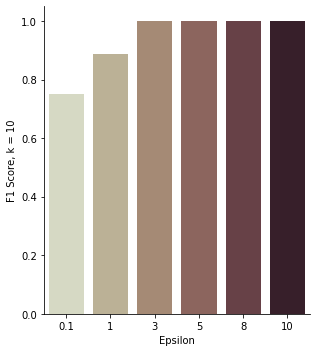

In [155]:
query_idades = top_k_reverse_idade(dataset_idade, 10)['idade']
f1_lap = f1_score(query_idades, idades, budgets)
plot_erros(f1_lap, 10)

# Mecanismo Exponencial

In [14]:
def score_function_exp(dataset):
    return -dataset['count']

In [15]:
def sensibilidade_exp(dataset, budget, k):
    smooth_functions = [1]*len(dataset['count'])
    beta = budget/k
    otimo = 0
    for smooth in smooth_functions:
        otimo = max(otimo, (smooth*math.exp(-beta)))
    return otimo

# Consulta Idade Exponencial

In [16]:
def exp_idades(budget, sensibilidade, dataset, k):
    budget = budget/k

    scores = score_function_exp(dataset)

    _users = list(dataset['idade'].copy())
    _scores = list(scores.copy())

    top = []

    for i_run in range(k):

        probabilities = []

        for j_score in _scores:
            probability = math.exp( (budget * j_score) / (2 * sensibilidade) )
            probabilities.append(probability)

        probabilities = [j_probability/sum(probabilities) for j_probability in probabilities]

        sample = random.choices(population=_users, weights=probabilities, k=1)[0]

        top.append(sample)

        _scores.remove(_scores[_users.index(sample)])
        _users.remove(sample)

    return top

In [186]:
idades_exp = []

for budget in budgets:
    b = exp_idades(budget, sensibilidade_exp(dataset_idade, budget, 10), dataset_idade, 10)
    b = np.array(b)
    print("epsilon: {}\nreverse top-k:\n{}\n\n".format(budget, b))
    idades_exp.append(b)

epsilon: 0.1
reverse top-k:
['[56:60]' '[81:85]' '[91:95]' '[6:10]' '[66:70]' '[16:20]' '[76:80]'
 '[11:15]' '[71:75]' '[1:5]']


epsilon: 1
reverse top-k:
['[11:15]' '[91:95]' '[6:10]' '[1:5]' '[86:90]' '[16:20]' '[81:85]'
 '[76:80]' '[66:70]' '[71:75]']


epsilon: 3
reverse top-k:
['[6:10]' '[11:15]' '[91:95]' '[1:5]' '[86:90]' '[16:20]' '[81:85]'
 '[76:80]' '[66:70]' '[71:75]']


epsilon: 5
reverse top-k:
['[6:10]' '[11:15]' '[91:95]' '[1:5]' '[86:90]' '[16:20]' '[81:85]'
 '[76:80]' '[66:70]' '[71:75]']


epsilon: 8
reverse top-k:
['[6:10]' '[91:95]' '[11:15]' '[1:5]' '[86:90]' '[16:20]' '[81:85]'
 '[76:80]' '[66:70]' '[71:75]']


epsilon: 10
reverse top-k:
['[6:10]' '[91:95]' '[11:15]' '[1:5]' '[86:90]' '[16:20]' '[81:85]'
 '[76:80]' '[66:70]' '[71:75]']




epsilon = 0.1:
Verdadeiros Positivos: 1
Falsos Positivos: 9
Falsos Negativos: 1


epsilon = 1:
Verdadeiros Positivos: 8
Falsos Positivos: 2
Falsos Negativos: 0


epsilon = 3:
Verdadeiros Positivos: 8
Falsos Positivos: 2
Falsos Negativos: 0


epsilon = 5:
Verdadeiros Positivos: 8
Falsos Positivos: 2
Falsos Negativos: 0


epsilon = 8:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 10:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


[0.16666666666666669, 0.888888888888889, 0.888888888888889, 0.888888888888889, 1.0, 1.0]


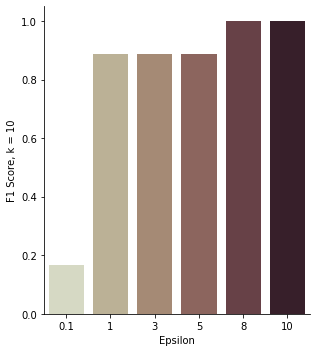

In [187]:
query_idades_exp = top_k_reverse_idade(dataset_idade, 10)['idade']
f1 = f1_score(query_idades_exp, idades_exp, budgets)
plot_erros(f1, 10)

# Calculando a média dos valores para cada epsilon
## Pros resultados não serem aleatórios

In [259]:
aux = []
query_idades_exp = top_k_reverse_idade(dataset_idade, 10)['idade']
for i in range(5):
    lista = []
    for eps in budgets:
        hm = np.array(exp_idades(eps, sensibilidade_exp(dataset_idade, eps, 10), dataset_idade, 10))
        lista.append(hm)
    f1 = f1_score(query_idades_exp, lista, budgets)
    aux.append(f1)
aux

epsilon = 0.1:
Verdadeiros Positivos: 1
Falsos Positivos: 9
Falsos Negativos: 1


epsilon = 1:
Verdadeiros Positivos: 6
Falsos Positivos: 4
Falsos Negativos: 0


epsilon = 3:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 5:
Verdadeiros Positivos: 8
Falsos Positivos: 2
Falsos Negativos: 0


epsilon = 8:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 10:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


[0.16666666666666669, 0.7499999999999999, 1.0, 0.888888888888889, 1.0, 1.0]
epsilon = 0.1:
Verdadeiros Positivos: 2
Falsos Positivos: 8
Falsos Negativos: 1


epsilon = 1:
Verdadeiros Positivos: 9
Falsos Positivos: 1
Falsos Negativos: 1


epsilon = 3:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 5:
Verdadeiros Positivos: 10
Falsos Positivos: 0
Falsos Negativos: 0


epsilon = 8:
Verdadeiros Positivos: 8
Falsos Positivos: 2
Falsos Negativos: 0


epsilon = 10:
Verdadeiros Positivo

[[0.16666666666666669, 0.7499999999999999, 1.0, 0.888888888888889, 1.0, 1.0],
 [0.30769230769230765, 0.9, 1.0, 1.0, 0.888888888888889, 1.0],
 [0.15384615384615383, 0.888888888888889, 1.0, 1.0, 1.0, 1.0],
 [0.28571428571428575, 0.7499999999999999, 0.888888888888889, 1.0, 1.0, 1.0],
 [0.30769230769230765,
  0.7499999999999999,
  0.888888888888889,
  0.888888888888889,
  1.0,
  1.0]]

In [260]:
que = []
for i in range(len(aux[0])):
    mano = []
    for j in range(len(aux)):
        mano.append(aux[j][i])
    que.append(mano)
medias = [0]*len(que)
for i in range(len(que)):
    medias[i] = np.mean(que[i])
medias

[0.24432234432234434,
 0.8077777777777777,
 0.9555555555555555,
 0.9555555555555555,
 0.9777777777777779,
 1.0]

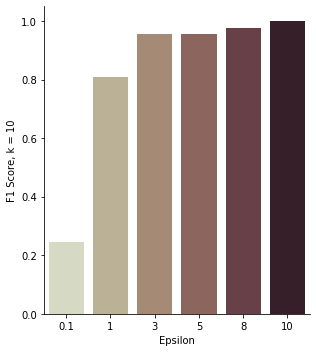

In [261]:
plot_erros(medias, 10)